In [1]:

import pandas as pd
from speechbrain.nnet.pooling import StatisticsPooling
from prepare import WaveformEncoder
import numpy as np

/home/lorenzg/miniconda3/envs/dicla_torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_path = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/data/at_augmented_regions'

# W2V2 embedding

In [75]:
from transformers import Wav2Vec2ForSequenceClassification, AutoFeatureExtractor
import torch
import soundfile as sf
import torchaudio
import pandas as pd
from speechbrain.pretrained import EncoderClassifier
from speechbrain.nnet.pooling import StatisticsPooling
from prepare import WaveformEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from tqdm import tqdm

# Load the model and processor once
model_id_w2v2 = "facebook/wav2vec2-large-xlsr-53"
processor_w2v2 = AutoFeatureExtractor.from_pretrained(model_id_w2v2)
model_w2v2 = Wav2Vec2ForSequenceClassification.from_pretrained(model_id_w2v2)
hparams_path = '/home/projects/vokquant/accent-recog-slt2022/notebooks/pretrained_models/CustomEncoderWav2vec2Classifier-5810915bb487fd3ae3f07221fcfd04b6/hyperparams.yaml'
test_path = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/data/at_augmented_regions'
test_items = pd.read_csv(f'{test_path}/test.csv')

use_finetuned_model = True
if use_finetuned_model == False:
    source_path = model_id_w2v2
elif use_finetuned_model == True:
    source_path = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/W2V2/AT/wav2vec2-large-xlsr-53-augmented/8001'
    hparams_path = f'{source_path}/hyperparams.yaml'

classifier = WaveformEncoder.from_hparams(source=model_id_w2v2, hparams_file=hparams_path)
# get model to cpu
classifier.mods.cpu()
def embeds(filepath):
    x, sr = sf.read(filepath)
    # speech, sample_rate = sf.read(audio_file)
    # make to tensor
    x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
    out = classifier.mods.wav2vec2(x)
    pooling_layer = StatisticsPooling(return_std=False)
    emb = pooling_layer(out).squeeze().cpu().numpy()
    # get detected language
    # lang = classifier.mods.classifier(out).argmax(-1).item()
    return emb



/home/lorenzg/miniconda3/envs/dicla_torch/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/lorenzg/miniconda3/envs/dicla_torch/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2ForSequenceClassification: ['quantizer.weight_proj.bias', 'project_hid.weight', 'project_q.weight', 'quantizer.codevectors', 'project_hid.bias', 'quantizer.weight_proj.weight', 'project_q.bias']
- This IS expected if you are initializing Wa

/home/projects/vokquant/accent-recog-slt2022/CommonAccent/data/rir_folder/rirs_noises.zip exists. Skipping download


/home/lorenzg/miniconda3/envs/dicla_torch/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2Model: ['quantizer.weight_proj.bias', 'project_hid.weight', 'project_q.weight', 'quantizer.codevectors', 'project_hid.bias', 'quantizer.weight_proj.weight', 'project_q.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a 

In [76]:
def load_audio(file_path, sample_rate=16000):
    waveform, original_sample_rate = torchaudio.load(file_path)
    if original_sample_rate != sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=original_sample_rate, new_freq=sample_rate)
        waveform = resampler(waveform)
    return waveform.squeeze().numpy()

def extract_features(audio, processor):
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    return inputs

def predict(audio_file, model, processor):
    audio = load_audio(audio_file)
    inputs = extract_features(audio, processor)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    return predicted_ids.item()

y_pred = []
y_true = test_items['accent']  # Assuming 'label' column exists in test.csv

for _, row in tqdm(test_items.iterrows(), total=len(test_items)):
    file_path = f"{row['wav']}"  # Assuming 'filename' column in test.csv
    pred = predict(file_path, model_w2v2, processor_w2v2)
    y_pred.append(pred)


100%|██████████| 2598/2598 [08:11<00:00,  5.28it/s]


In [77]:
embeddings = []
for index, row in tqdm(test_items.iterrows()):
    filepath = f"{row['wav']}"
    embeddings.append(embeds(filepath))

# TSNE
n_components = 2
tsne = TSNE(n_components=n_components)
tsne_result = tsne.fit_transform(np.array(embeddings))

2598it [07:47,  5.56it/s]


In [78]:
classes = y_true.unique()
# make dict with classes as keys and values
# class_dict = {classes[i]: i for i in range(len(classes))}
classes[0]
name_dict = {}
for i in range(len(classes)):
    name_dict[str(classes[i])] = str(classes[i])
reversed_name_dict = {v: k for k, v in name_dict.items()}
    
# make string labels
classes = [str(i) for i in classes]

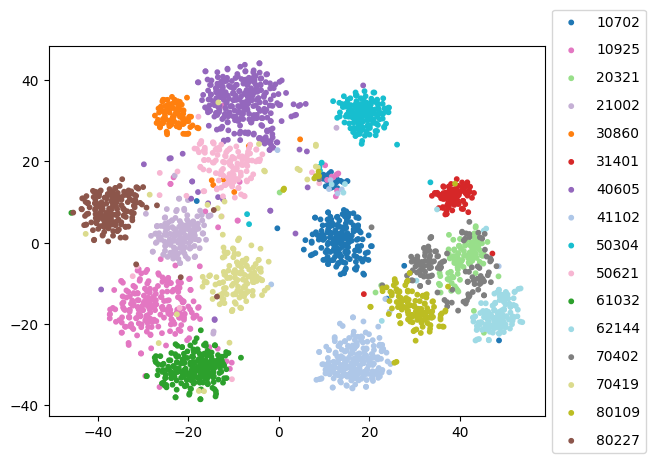

In [79]:
cmap = plt.get_cmap('tab20', len(classes))
fig, ax = plt.subplots()

# groups = pd.DataFrame(tsne_result, columns=['x', 'y']).assign(accent=test_items['accent']).groupby('accent')
groups = (
    pd.DataFrame(tsne_result, columns=['x', 'y'])
    .assign(accent=test_items['accent'].astype(str))
    .groupby('accent')
)
for name, points in groups:
    if name not in name_dict:
        print(f"Warning: {name} not found in name_dict")
        continue
    tfmd_classes = list(map(lambda x: reversed_name_dict[x], classes))
    c = cmap([classes.index(name_dict[name])] * len(points))
    ax.scatter(points.x, points.y, label=name_dict[name], s=10, color=c)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labelspacing=1);

In [53]:
# show first entry in groups
print(groups.first())

               x         y
accent                    
10702   0.087284 -0.986445
10925  -6.571884 -3.591134
20321   0.409852 -2.209414
21002  -1.385792 -2.933408
30860  -4.135744  0.422801
31401   0.896584  2.732477
40605  -1.520617 -5.411945
41102  -2.207355  1.324274
50304   0.625135 -5.965605
50621  -1.992229  0.300194
61032  -5.697145 -3.494107
62144  -0.649597  2.345659
70402   1.596882  1.691173
70419   3.823620 -3.093721
80109   3.550928 -0.442144
80227  -3.816673 -2.869134


99it [00:14,  7.05it/s]


In [ ]:
# get classes from model test items



AttributeError: 'WaveformEncoder' object has no attribute 'output_layer'

In [5]:
# Usage of the function
audio_file = "/home/projects/vokquant/fairseq/audio_samples/de.wav"  # Path to the audio file

detected_language, embeddings = get_embedding_w2v2(audio_file, model_w2v2, processor_w2v2)

print(f"Detected language: {detected_language}")
print("Embeddings shape:", embeddings.shape)

Detected language: LABEL_1
Embeddings shape: torch.Size([1, 1024])


# w2v2 compute embs

In [20]:
import os
from tqdm import tqdm
import pickle

# read test items
test_items = pd.read_csv(f'{test_path}/test.csv')
embeddings_w2v2 = []
accents = []

output_folder = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/W2V2/AT/wav2vec2-large-xlsr-53-augmented"
save_path = os.path.join(output_folder, "embeddings")
os.makedirs(save_path, exist_ok=True)

# go through all test items and get embeddings
for index, row in tqdm(test_items.iterrows()):
    if index % 10 != 0:
        continue
    else:
        # filepath = f"{test_path}/test/{row['utt_id']}.wav"
        filepath = f"{row['wav']}"
        filename = test_items.iloc[index].utt_id #filepath.split("/")[-1].replace(".wav", ".npy").replace(".mp3", ".npy")
        lang, emb_w2v2 = get_embedding_w2v2(filepath, model_w2v2, processor_w2v2)    
        accent = row['accent']
        embeddings_w2v2.append(emb_w2v2)
        accents.append(accent)

embeddings_w2v2 = [emb.numpy() for emb in embeddings_w2v2]
accents = np.array(accents)

with open(os.path.join("/home/projects/vokquant/accent-recog-slt2022/notebooks/pickle_files", "embeddings_w2v2.pkl"), "wb") as f:
    pickle.dump(embeddings_w2v2, f)

with open(os.path.join("/home/projects/vokquant/accent-recog-slt2022/notebooks/pickle_files", "embeddings_and_accents.pkl"), "wb") as f:
    pickle.dump((embeddings_w2v2, accents), f)

# open both files
with open(os.path.join("/home/projects/vokquant/accent-recog-slt2022/notebooks/pickle_files", "embeddings_w2v2.pkl"), "rb") as f:
    embeddings_w2v2 = pickle.load(f)
    
with open(os.path.join("/home/projects/vokquant/accent-recog-slt2022/notebooks/pickle_files", "embeddings_and_accents.pkl"), "rb") as f:
    accents = pickle.load(f)
# embeddings_w2v2 = np.array(embeddings_w2v2)
print("Embeddings shape: ", np.shape(embeddings_w2v2))
print("Accents shape: ", np.shape(accents))

5728it [01:19, 72.31it/s]

Embeddings shape:  (573, 1, 1024)
Accents shape:  (573,)


In [14]:
# print((embeddings_w2v2))
# make each tensor to numpy array
print(accents)

[10702, 10702, 30860, 80227, 30860, 61032, 80227, 41102, 41102, 10925, 31401, 50621, 61032, 70419, 70402, 50621, 62144, 61032, 10702, 30860, 40605, 50304, 70419, 80227, 10702, 70402, 40605, 31401, 31401, 62144, 62144, 61032, 10925, 70402, 62144, 40605, 70402, 70419, 10702, 10925, 41102, 10925, 41102, 20321, 50621, 21002, 31401, 61032, 80109, 41102, 21002, 21002, 20321, 70419, 10925, 10925, 20321, 41102, 10925, 21002, 50621, 80227, 61032, 41102, 21002, 80109, 70402, 30860, 50621, 50621, 20321, 30860, 10925, 40605, 10702, 62144, 61032, 80227, 50304, 10702, 40605, 10702, 80227, 10925, 70402, 20321, 70419, 21002, 10702, 80109, 62144, 70419, 80109, 50304, 20321, 10925, 21002, 70402, 40605, 80227, 30860, 40605, 61032, 70402, 61032, 41102, 61032, 30860, 62144, 61032, 41102, 80227, 80109, 41102, 50304, 10702, 61032, 70419, 31401, 40605, 40605, 10925, 61032, 50304, 21002, 62144, 41102, 30860, 80227, 61032, 61032, 80109, 80227, 40605, 40605, 70419, 10925, 50621, 31401, 50304, 10925, 80227, 20321

In [9]:
# array = []
# for x in embeddings_w2v2:
#     print(x[1].shape)
#     array.append(x[1])
embeddings_w2v22 = np.array([x for x in embeddings_w2v2])
# print(embeddings_w2v22)
# print(embeddings_w2v2[0][1].shape)
# embeddings_w2v22 = embeddings_w2v2[:, 1]

# embeddings_w2v22 = np.array(embeddings_w2v22)
print("Embeddings shape: ", np.shape(embeddings_w2v22))
print("Accents shape: ", np.shape(accents))

# squeeze middle dimension
embeddings_w2v23 = np.squeeze(embeddings_w2v22, axis=1)
print("Embeddings shape: ", np.shape(embeddings_w2v23))

Embeddings shape:  (573, 1, 1024)
Accents shape:  (573,)
Embeddings shape:  (573, 1024)


# w2v2 visualization

In [36]:
class_mapping = {
'62390': 0, '70221': 1, '30860': 2, '31035': 3, '50413': 4, '41706': 5, '70709': 6, '80105': 7, '40719': 8, '70334': 9, '70406': 10, '31405': 11, '32210': 12, '70627': 13, '50304': 14, '70706': 15, '31207': 16, '40702': 17, '40423': 18, '40410': 19, '32309': 20, '41411': 21, '10702': 22, '70208': 23, '70734': 24, '50626': 25, '80225': 26, '30501': 27, '70622': 28, '40621': 29, '50621': 30, '62216': 31, '41342': 32, '61032': 33, '30910': 34, '10903': 35, '50617': 36, '31110': 37, '70615': 38, '20622': 39, '20914': 40, '80411': 41, '50612': 42, '50502': 43, '61627': 44, '32324': 45, '70516': 46, '10925': 47, '40806': 48, '80239': 49, '20321': 50, '80227': 51, '70804': 52, '80128': 53, '41804': 54, '31652': 55, '61257': 56, '30719': 57, '60350': 58, '50509': 59, '70402': 60, '20619': 61, '10401': 62, '61628': 63, '70824': 64, '70606': 65, '50206': 66, '61254': 67, '62105': 68, '31916': 69, '50210': 70, '40402': 71, '61115': 72, '70908': 73, '70419': 74, '70366': 75, '61743': 76, '32518': 77, '40914': 78, '31617': 79, '31401': 80, '50212': 81, '80212': 82, '41501': 83, '70326': 84, '40605': 85, '70362': 86, '70217': 87, '62144': 88, '10428': 89, '32519': 90, '10612': 91, '41102': 92, '50618': 93, '32002': 94, '50506': 95, '21002': 96, '62135': 97, '20604': 98, '61251': 99, '50423': 100, '31814': 101, '70825': 102, '31551': 103, '80109': 104, '31204': 105, '61756': 106, '70920': 107, '70504': 108
}

male_female_dict = { 31401: 'M', 30860: 'W', 41102: 'M', 40605: 'W', 62144: 'M', 61032: 'W', 20321: 'M', 21002: 'W', 50304: 'M', 50621: 'W', 70402: 'M', 70419: 'W', 80109: 'M', 80227: 'W', 10702: 'M', 10925: 'W'}

class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
# Loop through each key-value pair in the class_mapping dictionary
for key, value in class_mapping.items():
    # Convert the value to string to check the first digit
    value_str = str(value)
    # Check the first character of the value to determine the Bundesland
    if value_str[0] == '1':
        class_mapping[key] = f"{value_str} bgld"
    elif value_str[0] == '2':
        class_mapping[key] = f"{value_str} ktn"
    elif value_str[0] == '3':
        class_mapping[key] = f"{value_str} noe"
    elif value_str[0] == '4':
        class_mapping[key] = f"{value_str} ooe"
    elif value_str[0] == '5':
        class_mapping[key] = f"{value_str} sbg"
    elif value_str[0] == '6':
        class_mapping[key] = f"{value_str} stmk"
    elif value_str[0] == '7':
        class_mapping[key] = f"{value_str} t"
    elif value_str[0] == '8':
        class_mapping[key] = f"{value_str} vbg"
    elif value_str[0] == '9':
        class_mapping[key] = f"{value_str} w"
    else:
        print(f"error: Unrecognized first digit '{value_str[0]}' for key '{key}'")

    # Check if the value is in the male_female_dict
    if int(value) in male_female_dict:
        # Append gender information from male_female_dict
        class_mapping[key] = f"{class_mapping[key]} {male_female_dict[int(value)]}"

print(class_mapping)

{0: '62390', 1: '70221', 2: '30860', 3: '31035', 4: '50413', 5: '41706', 6: '70709', 7: '80105', 8: '40719', 9: '70334', 10: '70406', 11: '31405', 12: '32210', 13: '70627', 14: '50304', 15: '70706', 16: '31207', 17: '40702', 18: '40423', 19: '40410', 20: '32309', 21: '41411', 22: '10702', 23: '70208', 24: '70734', 25: '50626', 26: '80225', 27: '30501', 28: '70622', 29: '40621', 30: '50621', 31: '62216', 32: '41342', 33: '61032', 34: '30910', 35: '10903', 36: '50617', 37: '31110', 38: '70615', 39: '20622', 40: '20914', 41: '80411', 42: '50612', 43: '50502', 44: '61627', 45: '32324', 46: '70516', 47: '10925', 48: '40806', 49: '80239', 50: '20321', 51: '80227', 52: '70804', 53: '80128', 54: '41804', 55: '31652', 56: '61257', 57: '30719', 58: '60350', 59: '50509', 60: '70402', 61: '20619', 62: '10401', 63: '61628', 64: '70824', 65: '70606', 66: '50206', 67: '61254', 68: '62105', 69: '31916', 70: '50210', 71: '40402', 72: '61115', 73: '70908', 74: '70419', 75: '70366', 76: '61743', 77: '325

In [38]:
ids = accents
print(ids.shape)
print("unique ids",np.unique(ids).shape)
print(type(ids))
class_mapping
# print(ids)

(573,)
unique ids (16,)
<class 'numpy.ndarray'>


{0: '62390 stmk',
 1: '70221 t',
 2: '30860 noe',
 3: '31035 noe',
 4: '50413 sbg',
 5: '41706 ooe',
 6: '70709 t',
 7: '80105 vbg',
 8: '40719 ooe',
 9: '70334 t',
 10: '70406 t',
 11: '31405 noe',
 12: '32210 noe',
 13: '70627 t',
 14: '50304 sbg',
 15: '70706 t',
 16: '31207 noe',
 17: '40702 ooe',
 18: '40423 ooe',
 19: '40410 ooe',
 20: '32309 noe',
 21: '41411 ooe',
 22: '10702 bgld',
 23: '70208 t',
 24: '70734 t',
 25: '50626 sbg',
 26: '80225 vbg',
 27: '30501 noe',
 28: '70622 t',
 29: '40621 ooe',
 30: '50621 sbg',
 31: '62216 stmk',
 32: '41342 ooe',
 33: '61032 stmk',
 34: '30910 noe',
 35: '10903 bgld',
 36: '50617 sbg',
 37: '31110 noe',
 38: '70615 t',
 39: '20622 ktn',
 40: '20914 ktn',
 41: '80411 vbg',
 42: '50612 sbg',
 43: '50502 sbg',
 44: '61627 stmk',
 45: '32324 noe',
 46: '70516 t',
 47: '10925 bgld',
 48: '40806 ooe',
 49: '80239 vbg',
 50: '20321 ktn',
 51: '80227 vbg',
 52: '70804 t',
 53: '80128 vbg',
 54: '41804 ooe',
 55: '31652 noe',
 56: '61257 stmk',


/home/lorenzg/miniconda3/envs/dicla_torch/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


16


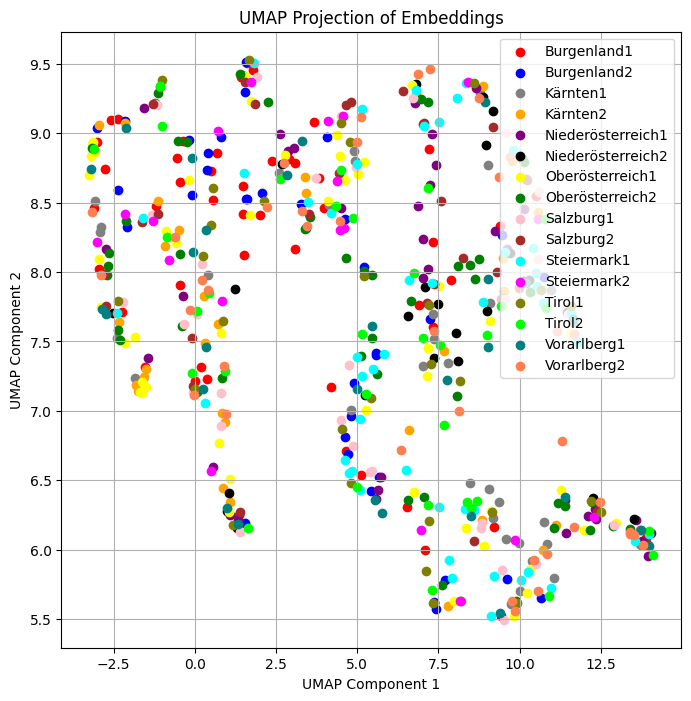

In [18]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Instantiate UMAP
umap_model = umap.UMAP(n_components=2, random_state=0)
X_embedded_umap = umap_model.fit_transform(X)

# classes = ['Burgenland1', 'Kärnten', 'Niederösterreich', 'Oberösterreich', 'Salzburg', 'Steiermark', 'Tirol', 'Vorarlberg']
classes = ['Burgenland1', 'Burgenland2', 'Kärnten1', 'Kärnten2', 'Niederösterreich1', 'Niederösterreich2', 'Oberösterreich1', 'Oberösterreich2', 'Salzburg1', 'Salzburg2', 'Steiermark1', 'Steiermark2', 'Tirol1', 'Tirol2', 'Vorarlberg1', 'Vorarlberg2']

# Define marker styles
markers = ['o', 's', 'D', '^', 'v', '>', '<', 'p', 'P', '*', 'X', 'd', 'H', 'h', '+']
colors = ['red', 'blue', 'grey', 'orange', 'purple', 'black', 'yellow', 'green', 'pink', 'brown', 'cyan', 'magenta', 'olive', 'lime', 'teal', 'coral']
print(len(colors))
# Plot the embeddings
plt.figure(figsize=(8, 8))
for i, (cls, embeddings_w2v23) in enumerate(emb_dict.items()):
    plt.scatter(X_embedded_umap[y == i, 0], X_embedded_umap[y == i, 1], 
                c=colors[i], label=classes[i], 
                # marker=markers[i % len(markers)],  # Use different markers
                # alpha=0.6,  # Add transparency
                # edgecolor='k',
                )  # Add a black edge color for better visibility

plt.title('UMAP Projection of Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.show()

/home/lorenzg/miniconda3/envs/dicla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lorenzg/miniconda3/envs/dicla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


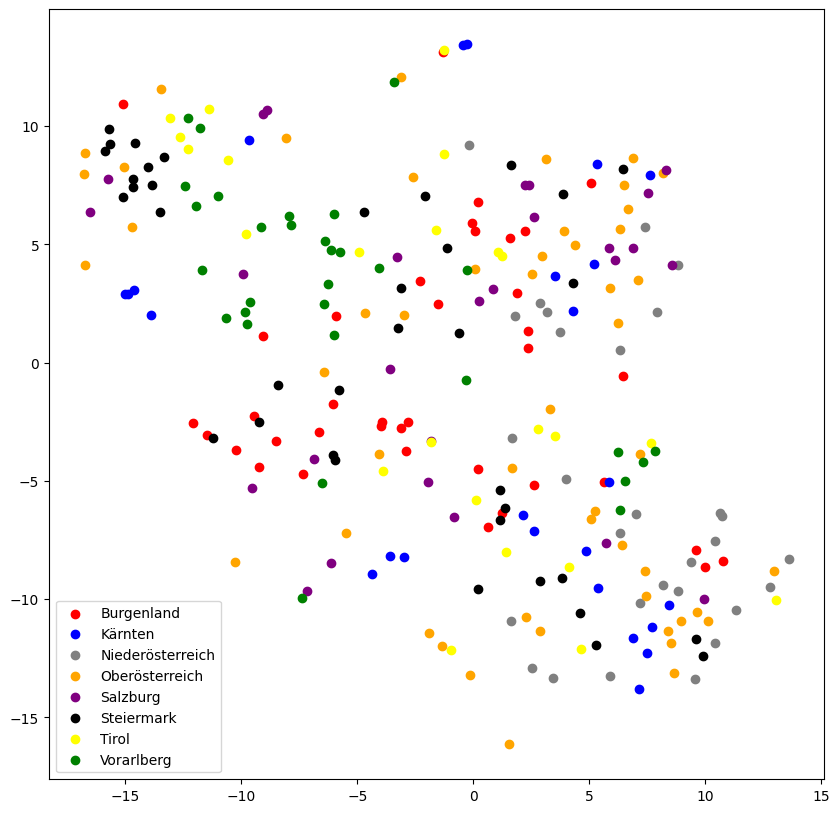

In [21]:
# make for tsne
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)

# Plot the embeddings
plt.figure(figsize=(8, 8))
colors = ['red', 'blue', 'grey', 'orange', 'purple', 'black', 'yellow', 'green']
for i, (cls, emb) in enumerate(emb_dict.items()):
    plt.scatter(X_embedded[y == i, 0], X_embedded[y == i, 1], c=colors[i], label=classes[i])  # Use classes[i] as label

# Add the legend with class names
plt.legend()
plt.show()

